In [5]:
folder = "/media/lenr/Data/semeds/Florian Ti (eds)/h5data/"

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd, json
import os

In [22]:
df = pd.read_csv(folder + "summary_table.csv")

records = [
    {
        "filename": row["basename"],
        "x": float(row["X_rel_um"]),
        "y": float(row["Y_rel_um"]),
        "width": float(row["TileWidth_um"]),
        "height": float(row["TileHeight_um"]),
    }
    for _, row in df.iterrows()
]

with open(folder + "adjusted_rectangles.json", "w") as f:
    json.dump(records, f, indent=2)

In [23]:
output_folder_tiles = folder + "processeddata/tiles"
output_folder_spectradata = folder + "processeddata/spectradata"
output_folder_spectraplots = folder + "processeddata/spectraplots"

In [24]:
# Specify the folder containing the files
input_folder = output_folder_tiles  # Replace with the path to your folder
output_file = "concatenated_data.txt"

# Open the output file
with open(output_file, "w") as outfile:
    # Loop through all files in the folder
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        # Only process files (ignore directories)
        if os.path.isfile(file_path):
            with open(file_path, "r") as infile:
                # Write the content of each file to the output file
                outfile.write(infile.read())
                #outfile.write("\n")  # Add a newline between files

print(f"Data concatenated into {output_file}")

Data concatenated into concatenated_data.txt


In [26]:
cols = ["base","stage_x_um","stage_y_um","row","col","frac_window_of_total"]
df = pd.read_csv(
    "concatenated_data.txt",
    comment="#",
    header=None,
    names=cols,
    skipinitialspace=True,
)
df

,base,stage_x_um,stage_y_um,row,col,frac_window_of_total
0,Project 1 Specimen 1 Area 2 Site 990 Map Data ...,49938.999176,11045.000076,0,0,0.039572
1,Project 1 Specimen 1 Area 2 Site 990 Map Data ...,49938.999176,11045.000076,0,1,0.039634
2,Project 1 Specimen 1 Area 2 Site 990 Map Data ...,49938.999176,11045.000076,0,2,0.036416
3,Project 1 Specimen 1 Area 2 Site 990 Map Data ...,49938.999176,11045.000076,1,0,0.040459
4,Project 1 Specimen 1 Area 2 Site 990 Map Data ...,49938.999176,11045.000076,1,1,0.040838
...,...,...,...,...,...,...
9580,Project 1 Specimen 1 Area 2 Site 989 Map Data ...,49929.000854,10510.999680,1,1,0.039862
9581,Project 1 Specimen 1 Area 2 Site 989 Map Data ...,49929.000854,10510.999680,1,2,0.034254
9582,Project 1 Specimen 1 Area 2 Site 989 Map Data ...,49929.000854,10510.999680,2,0,0.036731
9583,Project 1 Specimen 1 Area 2 Site 989 Map Data ...,49929.000854,10510.999680,2,1,0.034850


In [34]:
import os, numpy as np, pandas as pd
from collections import Counter

directory = output_folder_spectradata
npz_files = sorted(f for f in os.listdir(directory) if f.endswith(".npz"))

rows, key_counter, shape_counter, chan_counter = [], Counter(), Counter(), Counter()
CAND = {512, 1024, 2048, 4096}

def describe(arr):
    if not isinstance(arr, np.ndarray): return ("nonarray", None, None, None)
    shp, dt = tuple(arr.shape), arr.dtype
    if arr.ndim == 1:
        return ("1D", shp, int(shp[0]), 1)
    if arr.ndim == 2:
        h, w = shp
        if h in CAND and w not in CAND:   return ("2D", shp, int(h), int(w))
        if w in CAND and h not in CAND:   return ("2D", shp, int(w), int(h))
        # fallback: assume larger dim is channels
        ch = max(h, w); n = min(h, w)
        return ("2D", shp, int(ch), int(n))
    return (f"{arr.ndim}D", shp, None, None)

for fn in npz_files:
    path = os.path.join(directory, fn)
    try:
        with np.load(path, allow_pickle=False) as z:
            keys = list(z.files)
            key_counter.update(keys)
            # choose largest numeric array as "primary"
            best_k, best_size = None, -1
            for k in keys:
                a = z[k]
                if isinstance(a, np.ndarray) and a.size > best_size:
                    best_k, best_size = k, a.size
            kind, shp, channels, n_specs = describe(z[best_k]) if best_k else ("none", None, None, None)
            shape_counter.update([shp])
            if channels: chan_counter.update([channels])
            rows.append({
                "file": fn,
                "keys": ",".join(keys),
                "primary_key": best_k,
                "shape": shp,
                "dtype": str(z[best_k].dtype) if best_k else None,
                "kind": kind,
                "channels": channels,
                "spectra_in_file": n_specs
            })
    except Exception as e:
        rows.append({"file": fn, "keys": "ERROR", "primary_key": None, "shape": None,
                     "dtype": None, "kind": "error", "channels": None, "spectra_in_file": None})

df_npz = pd.DataFrame(rows)

# ---- Summary ----
print(f"NPZ files: {len(npz_files)}")
print(f"Readable files: {len(df_npz[df_npz['kind']!='error'])}, Errors: {len(df_npz[df_npz['kind']=='error'])}")
print("\nKind counts (1D vs 2D etc.):")
print(df_npz["kind"].value_counts().to_string())

print("\nTop keys:")
for k, c in key_counter.most_common(10):
    print(f"  {k}: {c}")

print("\nTop shapes:")
for s, c in shape_counter.most_common(10):
    print(f"  {s}: {c}")

print("\nChannel-length distribution (guessed):")
for ch, c in sorted(chan_counter.items()):
    print(f"  {ch}: {c} files")

# Peek at a few rows
display(df_npz.head(10))


NPZ files: 10650
Readable files: 10650, Errors: 0

Kind counts (1D vs 2D etc.):
kind
1D    9585
3D    1065

Top keys:
  spectrum: 9585
  spectra: 1065

Top shapes:
  (1024,): 9585
  (3, 3, 1024): 1065

Channel-length distribution (guessed):
  1024: 9585 files


,file,keys,primary_key,shape,dtype,kind,channels,spectra_in_file
0,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectra,spectra,"(3, 3, 1024)",float64,3D,NaN,NaN
1,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
2,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
3,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
4,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
5,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
6,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
7,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
8,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0
9,Project 1 Specimen 1 Area 2 Site 1 Map Data 12...,spectrum,spectrum,"(1024,)",float64,1D,1024.0,1.0


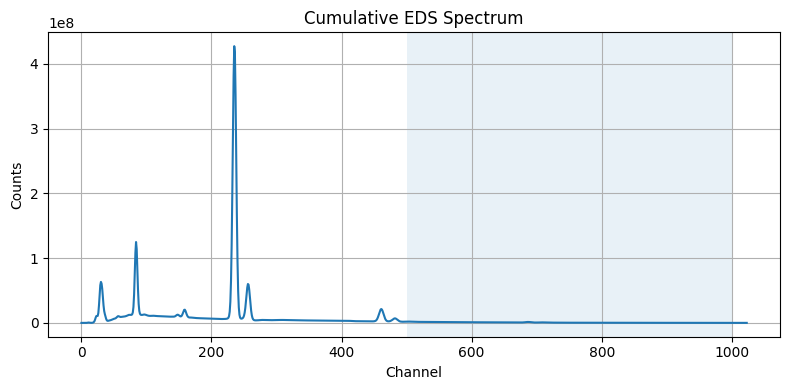

In [35]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

directory = output_folder_spectradata
win_start, win_end = 500, 1000

files = sorted(glob.glob(os.path.join(directory, "*_all-segments.npz")))
cum, rows = None, []

for path in files:
    with np.load(path, allow_pickle=False) as z:
        A = z["spectra"]              # (3,3,N)
        spec = A.sum((0,1))           # sum 3×3 → (N,)
        cum = spec if cum is None else cum + spec
        W = A[..., win_start:win_end+1].sum(-1)  # (3,3)
        t = os.path.splitext(os.path.basename(path))[0]
        rows += [{"tile": t, "r": r, "c": c, "intensity": float(W[r,c])}
                 for r in range(3) for c in range(3)]

np.save(os.path.join(directory, "cumulative_spectrum.npy"), cum)
df_parts = pd.DataFrame(rows).sort_values(["tile","r","c"])
df_parts.to_csv(os.path.join(directory, "tile_part_intensities.csv"), index=False)

plt.figure(figsize=(8,4))
plt.plot(cum); plt.axvspan(win_start, win_end, alpha=.1)
plt.title("Cumulative EDS Spectrum"); plt.xlabel("Channel"); plt.ylabel("Counts"); plt.grid(True); plt.tight_layout(); plt.show()


count=9585, min=0.00433034, max=0.0538638, mean=0.0373828


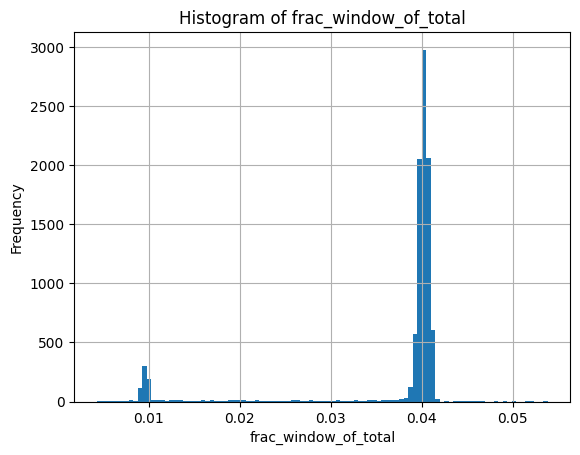

In [27]:
# pull the numeric series
vals = pd.to_numeric(df["frac_window_of_total"], errors="coerce").dropna().to_numpy()

# stats
print(f"count={vals.size}, min={vals.min():.6g}, max={vals.max():.6g}, mean={vals.mean():.6g}")

# histogram
plt.hist(vals, bins=100)
plt.title("Histogram of frac_window_of_total")
plt.xlabel("frac_window_of_total")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [30]:
directory = output_folder_spectradata

files = sorted(f for f in os.listdir(directory) if f.endswith(".npz"))
cumulative = None
max_len = 0
buffers = []

for fn in files:
    with np.load(os.path.join(directory, fn), allow_pickle=False) as z:
        key = "spectrum" if "spectrum" in z.files else z.files[0]
        s = np.asarray(z[key], dtype=np.float64).ravel()
        buffers.append(s)
        max_len = max(max_len, s.size)

# pad to common length and sum
cumulative = np.zeros(max_len, dtype=np.float64)
for s in buffers:
    if s.size == max_len:
        cumulative += s
    else:
        tmp = np.zeros(max_len, dtype=np.float64)
        tmp[:s.size] = s
        cumulative += tmp

print(f"Summed {len(files)} spectra → length {cumulative.size}")
# optional: save
# np.save("cumulative_spectrum.npy", cumulative)

Summed 10650 spectra → length 9216


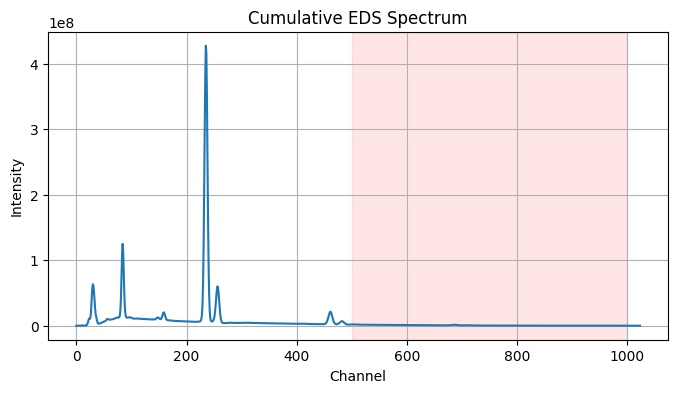

In [33]:
window_start, window_end = 500, 1000

if 'cumulative' in locals() and cumulative is not None:
    n = cumulative.size
    a = max(0, int(window_start))
    b = min(n - 1, int(window_end))

    plt.figure(figsize=(8, 4))
    plt.plot(cumulative, label="Cumulative Spectrum")
    plt.title("Cumulative EDS Spectrum")
    plt.xlabel("Channel")
    plt.ylabel("Intensity")
    plt.grid(True)
    plt.axvspan(a, b, color="red", alpha=0.1, label="Window of Interest")

    plt.savefig("Cumulative_EDS_Spectrum.png", format="png", bbox_inches="tight")
    plt.show()
else:
    print("No spectra summed; 'cumulative' is None.")

In [36]:
import json, os

# per-cell size in microns (0.549… µm/px × pixels / 3)
cell_w = 0.5490099191665649 * 1024 / 3
cell_h = 0.5490099191665649 * 768  / 3

rects = [
    {
        "filename": os.path.basename(f"{r.base}_seg-r{int(r.row)}_c{int(r.col)}.png"),
        "x": float(r.stage_x_um) - int(r.col) * cell_w,
        "y": float(r.stage_y_um) + int(r.row) * cell_h,
        "width":  cell_w,
        "height": cell_h,
        "intensity": float(r.frac_window_of_total),
    }
    for _, r in df.iterrows()
]

with open("adjusted_intensity_rectangles.json", "w") as f:
    json.dump(rects, f, indent=2)


In [32]:
import os, numpy as np

directory = output_folder_spectradata
files = sorted(f for f in os.listdir(directory) if f.endswith(".npz"))

def extract_1d(z):
    # prefer common keys; fall back to first
    for k in ("spectrum", "counts", "intensity", "y"):
        if k in z.files: key = k; break
    else:
        key = z.files[0]
    a = np.asarray(z[key], dtype=np.float64)

    if a.ndim == 1:                          # already one spectrum
        return a

    if a.ndim == 2:                          # many spectra x channels (or vice versa)
        h, w = a.shape
        # pick channel dimension if it looks like 512–4096
        candidates = {512, 1024, 2048, 4096}
        if h in candidates and w not in candidates:
            return a.sum(axis=0)             # sum over spectra, keep channels
        if w in candidates and h not in candidates:
            return a.sum(axis=1)
        # fallback: assume larger dim is channels
        ax = 0 if h >= w else 1
        return a.sum(axis=1-ax)

    # unexpected shapes: skip
    return None

cumulative = None
for fn in files:
    with np.load(os.path.join(directory, fn), allow_pickle=False) as z:
        s = extract_1d(z)
        if s is None: 
            continue
        if cumulative is None:
            cumulative = s.copy()
        else:
            # pad to max length if needed
            if s.size > cumulative.size:
                cumulative = np.pad(cumulative, (0, s.size - cumulative.size))
            elif s.size < cumulative.size:
                s = np.pad(s, (0, cumulative.size - s.size))
            cumulative += s

if cumulative is None:
    print("No usable spectra found.")
else:
    print(f"Summed {len(files)} files → {cumulative.size} channels")


Summed 10650 files → 1024 channels


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `data` contains the content of the concatenated file as a string
# Split the data into rows
rows = data.strip().split("\n")

# Extract the last value from each row and convert it to a float
values = np.array([float(row.split(",")[-1]) for row in rows])

# Calculate statistics
min_value = np.min(values)
max_value = np.max(values)
mean_value = np.mean(values)

# Display statistics
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")
print(f"Mean Value: {mean_value}")

# Plot histogram
plt.hist(values, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Last Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

ValueError: could not convert string to float: ' frac_window_of_total'

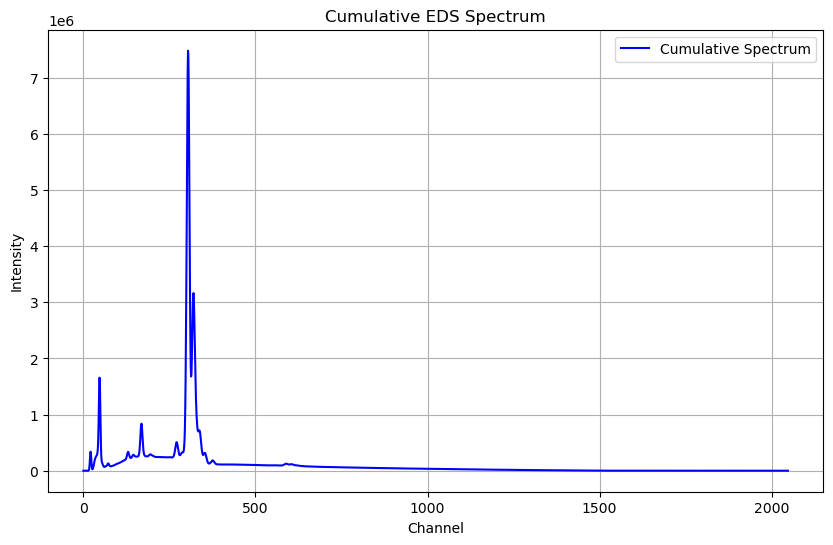

In [106]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory containing the .npz files
directory = output_folder_spectradata

# Initialize the cumulative spectrum
cumulative_spectrum = None

# Loop through all .npz files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".npz"):
        filepath = os.path.join(directory, filename)
        
        # Load the spectrum from the .npz file
        data = np.load(filepath)
        spectrum = data[data.files[0]]  # Assuming the spectrum is the first item
        
        # Add to the cumulative spectrum
        if cumulative_spectrum is None:
            cumulative_spectrum = spectrum
        else:
            cumulative_spectrum += spectrum


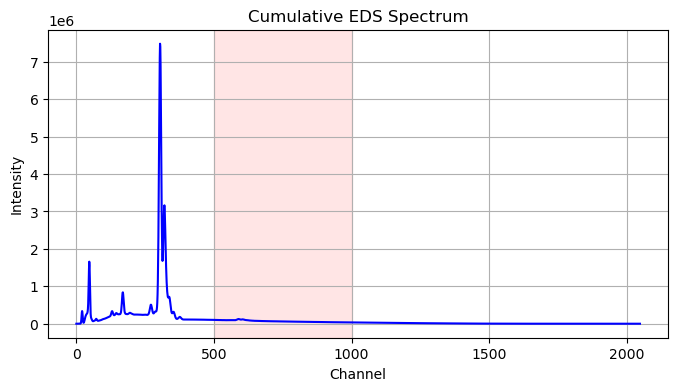

In [113]:
window_start = 500
window_end = 1000

# Plot the cumulative spectrum
if cumulative_spectrum is not None:
    plt.figure(figsize=(8, 4))
    plt.plot(cumulative_spectrum, label='Cumulative Spectrum', color='blue')
    plt.title("Cumulative EDS Spectrum")
    plt.xlabel("Channel")
    plt.ylabel("Intensity")
    #plt.legend()
    plt.grid(True)

    plt.axvspan(window_start, window_end, color='red', alpha=0.1, label="Window of Interest")
    
    # Save the plot as a .png file
    output_path = "Cumulative_EDS_Spectrum.png"
    plt.savefig(output_path, format='png', bbox_inches='tight')
    plt.show()
else:
    print("No .npz files found in the directory.")

In [125]:
import json
import os

# File parsing constants
rectangle_width = (0.5490099191665649 * 1024) / 2  # Half width in microns
rectangle_height = (0.5490099191665649 * 768) / 2  # Half height in microns
rectangle_width_pixels = (1024) / 2  # Half width in microns
rectangle_height_pixels = (768) / 2  # Half height in microns

# Parse the input data
rectangles = []

for line in data.strip().split("\n"):

    filename, stage_x, stage_y, quadrant_x, quadrant_y, intensity = line.split(",")
    stage_x, stage_y, intensity = map(float, [stage_x, stage_y, intensity])
    quadrant_x, quadrant_y = map(int, [quadrant_x, quadrant_y])
    
    
    x_rect = stage_x - quadrant_y * rectangle_width
    y_rect = (stage_y + quadrant_x * rectangle_height)* 1.01

    spectrum_filename = os.path.join(f"{filename}_quadrant-{quadrant_x}-{quadrant_y}.png")
    
    rectangles.append({"filename": spectrum_filename, "x": x_rect, "y": y_rect,"intensity": intensity})

# Given min_x and min_y for adjustment
min_x = -97234.3 # in pixels
min_y = 45306.68960571289+453.06689605712745 # in microns 

# Adjust coordinates
for rect in rectangles:
    rect["x"] = -((rect["x"] + (min_x * 0.5490099191665649))) / 0.5490099191665649
    rect["y"] = (rect["y"]) * 1.01 - min_y
    rect["y"] = (rect["y"]) * 1.8
    rect["width"] = rectangle_width
    rect["height"] = rectangle_height* 1.01

# Save to a JSON file
output_file = "adjusted_intensity_rectangles2.json"
with open(output_file, "w") as f:
    json.dump(rectangles, f, indent=4)

output_file

'adjusted_intensity_rectangles2.json'

In [89]:
rectangle_width_pixels

512.0

In [76]:
rectangle_height_pixels

384.0